In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import joblib
from matplotlib import gridspec
from scipy.sparse import hstack
from scipy import sparse
import warnings
import pickle

warnings.filterwarnings("ignore")

In [ ]:
book = pd.read_csv("/content/drive/MyDrive/Content-Based-Recommendation/data.csv")

In [ ]:
book.head()

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
print(book["image_link"][0])

https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1350395884l/16043519.jpg


In [ ]:
book.columns

Index(['Unnamed: 0', 'Desc', 'Unnamed: 0.1', 'author', 'genre', 'image_link',
       'rating', 'title'],
      dtype='object')

In [ ]:
book = book.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
book.head()

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
book.columns

Index(['Desc', 'author', 'genre', 'image_link', 'rating', 'title'], dtype='object')

In [ ]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Desc        2382 non-null   object 
 1   author      2382 non-null   object 
 2   genre       2382 non-null   object 
 3   image_link  2382 non-null   object 
 4   rating      2382 non-null   float64
 5   title       2382 non-null   object 
dtypes: float64(1), object(5)
memory usage: 111.8+ KB


In [ ]:
#book = book.drop(1886)
#book = book.drop(1025)
#book = book.drop(532)

In [ ]:
book.to_pickle('books_final.pkl')

In [ ]:
print(book['title'].describe())

count               2382
unique              2378
top       Atlas Shrugged
freq                   2
Name: title, dtype: object


In [ ]:
print(book['genre'].unique())

['Business' 'Non-Fiction']


In [ ]:
# find the 10 most frequent author_names.
product_type_count = Counter(list(book['author']))
product_type_count.most_common(10)

[('Stephen King', 34),
 ('Seth Godin', 15),
 ('John C. Maxwell', 15),
 ('C.S. Lewis', 13),
 ('John Grisham', 13),
 ('Neil Gaiman', 12),
 ('Haruki Murakami', 12),
 ('Margaret Atwood', 11),
 ('Jodi Picoult', 11),
 ('Patrick Lencioni', 10)]

In [ ]:
book.isnull().sum()

Desc          0
author        0
genre         0
image_link    0
rating        0
title         0
dtype: int64

In [ ]:
book.index[book['title'] == "The Four Pillars of Investing"].tolist()

[3]

# Text pre-processing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

list of stop words: {"won't", 'having', 'its', "couldn't", 'my', 'when', 'yourselves', "that'll", "shan't", 'while', 'under', 'myself', 'ourselves', 'themselves', 'wasn', 'm', "haven't", 'does', 'couldn', 'were', 're', "aren't", 'further', 'itself', 'herself', 'just', 'to', 'some', 'such', "isn't", "doesn't", 'above', "shouldn't", 'i', 'wouldn', 'shouldn', 'because', 'aren', 'can', "you'd", 'shan', "wasn't", 'doing', 'which', 'after', 'only', 'is', 'had', 'now', 'are', 'she', 'who', 'should', 'they', 'as', 'haven', "mustn't", 'ma', 'these', 'other', 'than', 'out', 'his', 'in', 'with', 'down', 'been', 'again', 'most', 'yourself', 'was', 'why', 'more', "didn't", 'all', 'mustn', 'me', 'through', 'won', 'an', "needn't", 'if', 'but', 'did', 'from', 't', 'her', "you're", 's', 'here', 'didn', 'and', 'too', 'him', 'we', 'be', 'for', 'by', 'how', 'o', 'have', "don't", 'between', "wouldn't", 'ain', 'each', 'during', 'a', 'up', 'has', 'until', "hasn't", 'you', 'on', 'below', 'same', 'off', 'any',

In [ ]:
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        book[column][index] = string

In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in book.iterrows():
    nlp_preprocessing(row['Desc'], index, 'Desc')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

1.4419909999999998 seconds


In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in book.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.7157269999999993 seconds


In [ ]:
start_time = time.clock()
# we take each author name and we text-preprocess it.
for index, row in book.iterrows():
    nlp_preprocessing(row['author'], index, 'author')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.6884189999999997 seconds


In [ ]:
start_time = time.clock()
# we take each author name and we text-preprocess it.
for index, row in book.iterrows():
    nlp_preprocessing(row['genre'], index, 'genre')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.6560769999999998 seconds


In [ ]:
book.head()

,Desc,author,genre,image_link,rating,title
0,know power shifting west east north south pres...,moisés naím,business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,end power boardrooms battlefields churches sta...
1,following success accidental billionaires mone...,blake j harris,business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,console wars sega nintendo battle defined gene...
2,tap power social software networks build busin...,chris brogan,business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,trust agents using web build influence improve...
3,william j bernstein american financial theoris...,william j bernstein,business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,four pillars investing
4,amazing book joined steve jobs many akio morit...,akio morita,business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,made japan akio morita sony


## Bag of Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(book['title'])
joblib.dump(title_vectorizer, 'title_vect.pkl')
title_features.get_shape() 

(2382, 3922)

In [ ]:
#desc_vectorizer = CountVectorizer()
#desc_features = desc_vectorizer.fit_transform(book['Desc'])
#desc_features.get_shape()

author_vectorizer = CountVectorizer()
author_features = author_vectorizer.fit_transform(book['author'])
joblib.dump(author_vectorizer, 'author_vect.pkl')
author_features.get_shape()

genre_vectorizer = CountVectorizer()
genre_features = genre_vectorizer.fit_transform(book['genre'])
joblib.dump(genre_vectorizer, 'genre_vect.pkl')
genre_features.get_shape()

(2382, 2)

In [ ]:
full_features = hstack((title_features, author_features, genre_features)).tocsr()

In [ ]:
full_features.shape

(2382, 5926)

In [ ]:
print(type(full_features))

<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
sparse.save_npz("finalfeatures.npz", full_features)

TITLE : hamlet 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 0.0
TITLE : othello 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.4142135623730951
TITLE : macbeth 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.4142135623730951
TITLE : tempest 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.4142135623730951
TITLE : merchant venice 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.7320508075688772
TITLE : romeo juliet 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.7320508075688772
TITLE : king lear 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the query image : 1.7320508075688772
TITLE : julius caesar 
AUTHOR: william shakespeare 
Genre: nonfiction 
Euclidean similarity with the quer

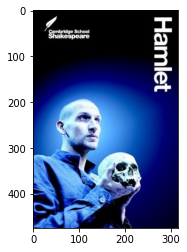

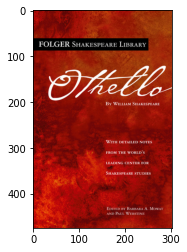

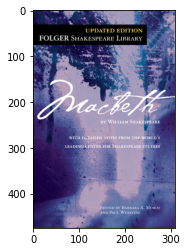

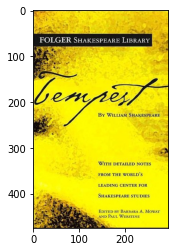

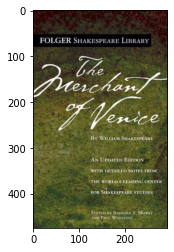

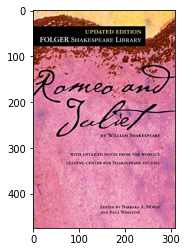

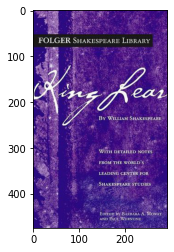

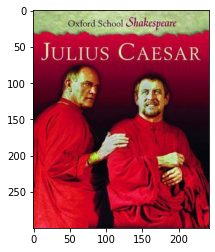

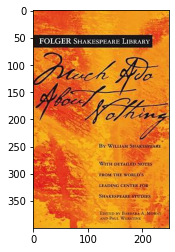

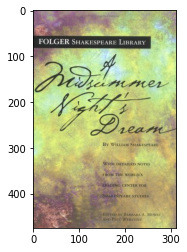

In [ ]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(full_features,full_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(book.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('TITLE :',book['title'].loc[df_indices[i]])
        print ('AUTHOR:', book['author'].loc[df_indices[i]])
        print ('Genre:', book['genre'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        response = requests.get(book['image_link'].loc[df_indices[i]])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(1391, 10) # change the index if you want to.

## Text Semantics based similarity

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
#loading pretrained google model
EMBEDDING_FILE = "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz"

model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [ ]:
words = set() 
for i in book["title"]:
  for j in i.split():
    words.add(j)


In [ ]:
title_words = list(words)

In [ ]:
vocab = model.wv.vocab.keys()

In [ ]:
vocab1 = list(vocab)

In [ ]:
words_vector = dict()
for i in words:
  if i in vocab1:          
    words_vector[i] = model[i]


In [ ]:
len(words)

3934

In [ ]:
type(words_vector)

dict

In [ ]:
with open('title_vec.pickle', 'wb') as handle:
    pickle.dump(words_vector, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Average Word2Vec product similarity.

In [ ]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.wv.vocab.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [ ]:

doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in book['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


In [ ]:
with open('sent_vect.pkl','wb') as f:  
  pickle.dump(w2v_title, f)

TITLE : blockchain revolution technology behind bitcoin changing money business world 
AUTHOR: tapscott 
Genre: business 
Euclidean similarity with the query image : 0.0
TITLE : alibabas world remarkable chinese company changing face global business 
AUTHOR: porter erisman 
Genre: business 
Euclidean similarity with the query image : 0.77787197
TITLE : holacracy new management system rapidly changing world 
AUTHOR: brian j robertson 
Genre: business 
Euclidean similarity with the query image : 0.84108233
TITLE : platform revolution networked markets transforming economyand make work 
AUTHOR: geoffrey g parker 
Genre: business 
Euclidean similarity with the query image : 0.84585875
TITLE : age cryptocurrency bitcoin digital money challenging global economic order 
AUTHOR: paul vigna 
Genre: business 
Euclidean similarity with the query image : 0.8543936
TITLE : behind cloud untold story salesforcecom went idea billiondollar companyand revolutionized industry 
AUTHOR: marc benioff 
Genre

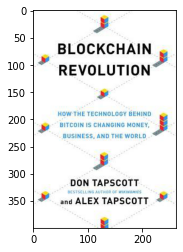

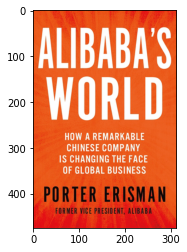

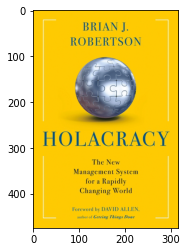

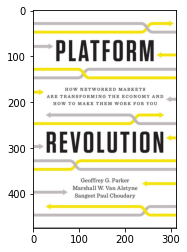

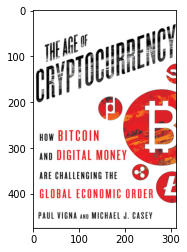

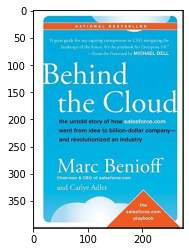

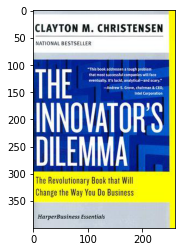

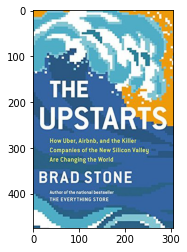

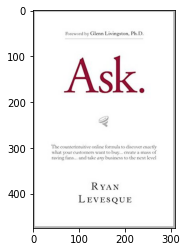

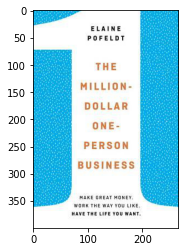

In [ ]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(book.index[indices])
    
    for i in range(0, len(indices)):
        #heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('TITLE :',book['title'].loc[df_indices[i]])
        print ('AUTHOR:', book['author'].loc[df_indices[i]])
        print ('Genre:', book['genre'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        response = requests.get(book['image_link'].loc[df_indices[i]])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        print('='*60)

        
avg_w2v_model(13, 10)